In this Notebook, EDA is done and after data cleaning and modification in regard with omitting outliers and also focusing on special part of data, modeling techniques are compared in term of R-square for train and test sets.

# Importing Libraries

In [1]:
# importing required libraries
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import plotly.express as px

from bs4 import BeautifulSoup as BS
import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import  ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

import time

ModuleNotFoundError: No module named 'plotly'

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')

# EDA and data modification

In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**omitting the extra and meaningless part of the date column**

In [5]:
data['date'] = data.apply(lambda x: x.date[0:8], axis=1)

**Creating an "age" column based on date of selling and date of built**

In [6]:
data['age'] = data.apply(lambda x: int(x.date[0:4]) - x.yr_built, axis=1)

**Creating an "age_renovated" column based on date of selling and date of renovation**

In [7]:
data['age_renovated'] = data.apply(lambda row: row.age if row.yr_renovated == 0 else int(row.date[0:4]) - row.yr_renovated, axis = 1)

In [8]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age,age_renovated
0,7129300520,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,59,59
1,6414100192,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,63,23
2,5631500400,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,82,82
3,2487200875,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,49,49
4,1954400510,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,28,28


In [9]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'age_renovated'],
      dtype='object')

In [10]:
data = data[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'age', 'yr_renovated',  'age_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]

In [11]:
data.sample(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,age,yr_renovated,age_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
19331,123039176,20141212,399888.0,4,1.00,2370,30200,1.5,0,0,...,800,1948,66,0,66,98146,47.5108,-122.366,1640,9719
15979,1972201305,20140729,500000.0,2,2.00,1250,3360,1.0,0,0,...,0,1957,57,0,57,98103,47.6526,-122.349,1250,3360
708,5231000060,20140805,310000.0,3,1.75,1490,7150,1.0,0,0,...,0,1967,47,0,47,98059,47.5015,-122.124,1350,9100
11550,2896000510,20140821,490000.0,4,2.50,2120,7820,1.0,0,0,...,840,1975,39,0,39,98052,47.6743,-122.145,2350,8605
16872,3797310010,20140827,277000.0,3,2.25,2160,9612,2.0,0,0,...,0,1994,20,0,20,98022,47.1927,-122.011,1970,9247


In [12]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'age', 'yr_renovated',
       'age_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [13]:
df = data.copy()

In [14]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
age              0
yr_renovated     0
age_renovated    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  age            21613 non-null  int64  
 16  yr_renovated   21613 non-null  int64  
 17  age_renovated  21613 non-null  int64  
 18  zipcod

In [16]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,age,yr_renovated,age_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,...,291.509045,1971.005136,43.317818,84.402258,40.936936,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,...,442.575043,29.373411,29.375493,401.679240,28.813643,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,0.000000,1900.000000,-1.000000,0.000000,-1.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,1951.000000,18.000000,0.000000,15.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,...,0.000000,1975.000000,40.000000,0.000000,37.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,...,560.000000,1997.000000,63.000000,0.000000,60.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,4820.000000,2015.000000,115.000000,2015.000000,115.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


**Creating a new column which includes the price of each square meter of the property**

In [17]:
df['persqft']= df['price'] / df['sqft_living']

In [18]:
df['persqft']

0        188.050847
1        209.338521
2        233.766234
3        308.163265
4        303.571429
            ...    
21608    235.294118
21609    173.160173
21610    394.216667
21611    250.000000
21612    318.627451
Name: persqft, Length: 21613, dtype: float64

In [19]:
df.shape

(21613, 24)

In [20]:
print(df.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
age                int64
yr_renovated       int64
age_renovated      int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
persqft          float64
dtype: object


In [21]:
df = df[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'age', 'yr_renovated',
       'age_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15']]

In [22]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,persqft,floors,waterfront,...,sqft_basement,yr_built,age,yr_renovated,age_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900.0,3,1.00,1180,5650,188.050847,1.0,0,...,0,1955,59,0,59,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000.0,3,2.25,2570,7242,209.338521,2.0,0,...,400,1951,63,1991,23,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000.0,2,1.00,770,10000,233.766234,1.0,0,...,0,1933,82,0,82,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000.0,4,3.00,1960,5000,308.163265,1.0,0,...,910,1965,49,0,49,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000.0,3,2.00,1680,8080,303.571429,1.0,0,...,0,1987,28,0,28,98074,47.6168,-122.045,1800,7503


**requesting the data for zip codes and their related city from a website**

In [23]:
url = "https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033"
data = requests.get(url)
soup = BS(data.text,'html.parser')

**scraping the website and saving the zipcode and city pairs in a dictionary**

In [24]:
ZipCode_dict = {}
for i in soup.find_all(border = '3'):

    for j in i.find_all('tr'):
        k = j.find(align='left')
        if k!= None:
            zip = int(k.get_text())
            city = k.next_sibling.next_sibling.get_text()
            ZipCode_dict[zip]=city

**creating a new column based on the zipcode column and the dictionary**

In [25]:
df['city'] = df["zipcode"].map(ZipCode_dict)

In [26]:
df.isnull().sum()

id                 0
date               0
price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
persqft            0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
age                0
yr_renovated       0
age_renovated      0
zipcode            0
lat                0
long               0
sqft_living15      0
sqft_lot15         0
city             198
dtype: int64

In [27]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'city'],
      dtype='object')

In [28]:
df = df[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'city', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']]

In [29]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [30]:
#what percent of the properties have waterfront
df['waterfront'].value_counts(normalize=True)*100

0    99.245824
1     0.754176
Name: waterfront, dtype: float64

**table for grade versus waterfront**

In [31]:
pd.crosstab(df.waterfront, df.grade )

grade,1,3,4,5,6,7,8,9,10,11,12,13
waterfront,,,,,,,,,,,,
0,1,3,29,238,2026,8958,6028,2590,1106,379,79,13
1,0,0,0,4,12,23,40,25,28,20,11,0


In [32]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'city', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

**plotting price versus some of other independent variables**

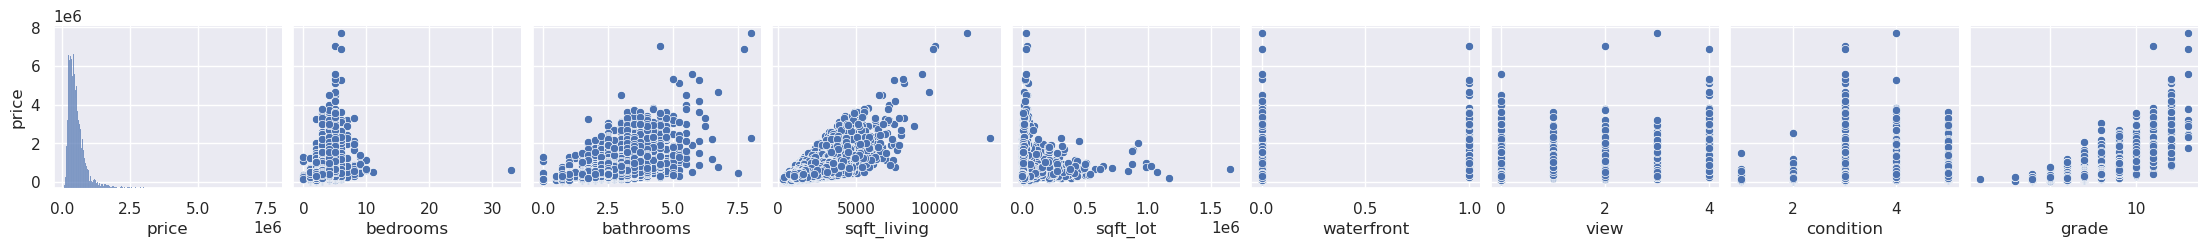

In [33]:
sns.pairplot(data=df,
             x_vars = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade'],
             y_vars=['price'])
plt.show()

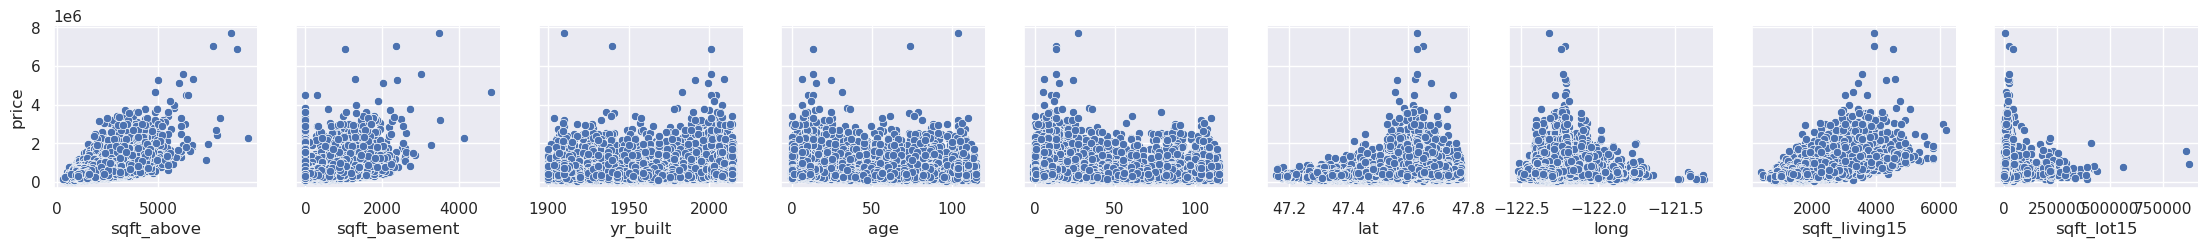

In [34]:
sns.pairplot(data=df,
             x_vars = ['sqft_above', 'sqft_basement', 'yr_built', 'age', 'age_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
             y_vars=['price'])
plt.show()

In [35]:
below_900 = df[ df.sqft_living <= 900 ]
len(below_900)

915

In [36]:
df[ df.sqft_living <= 1000 ]["waterfront"].value_counts(normalize=True)*100

0    99.531459
1     0.468541
Name: waterfront, dtype: float64

In [37]:
df.city.unique()

array(['Tukwila', 'Seattle', 'Bothell', 'Redmond', 'Federal Way',
       'Maple Valley', 'Bellevue', 'Duvall', 'Auburn', 'Shoreline',
       'Mercer Island', 'Kent', 'Issaquah', 'Renton', 'Vashon',
       'Yarrow Point', 'Kirkland', 'Black Diamond', 'North Bend', nan,
       'Snoqualmie', 'Enumclaw', 'Fall City', 'Woodinville', 'Carnation',
       'Medina'], dtype=object)

In [38]:
len(df.city.unique())

26

In [39]:
df = df[df['sqft_living'] < 5000]
df= df[ (df['persqft'] < np.quantile(df['persqft'], .95)) & (df['persqft'] > np.quantile(df['persqft'], .05))]

In [40]:
df.reset_index(drop = True, inplace = True)

In [41]:
df_to_plot = df.copy()
df_to_plot['bedrooms'] = df_to_plot['bedrooms'].apply(str)

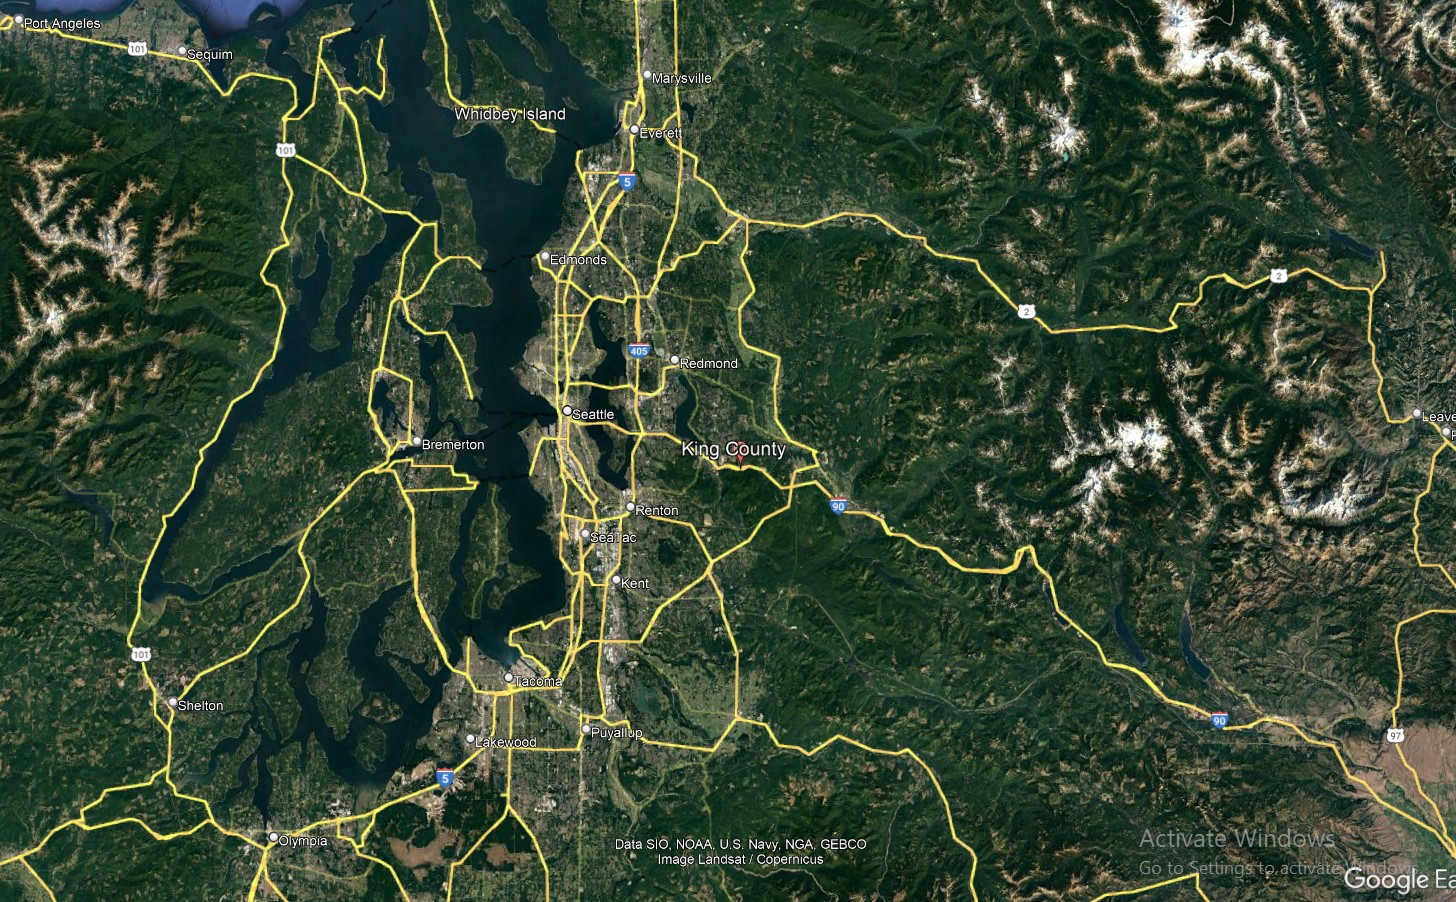

In [42]:
fig = px.scatter(df_to_plot, x="long", y="lat", color='bedrooms', size = 'price', hover_name='city',
                 labels={"bedrooms": "Number of Bedrooms"})
fig.show()

In [43]:
bedroom_bathroom_mean_df = df.groupby(['bedrooms','waterfront'])['price'].mean().reset_index()
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
bedroom_bathroom_mean_df

,bedrooms,waterfront,price
0,0,0,"468,855.000"
1,1,0,"281,045.903"
2,1,1,"285,000.000"
3,2,0,"373,762.924"
4,2,1,"639,372.800"
5,3,0,"448,969.539"
6,3,1,"834,245.833"
7,4,0,"607,648.059"
8,4,1,"866,954.545"
9,5,0,"709,775.874"


In [44]:
df2 = df.copy()

In [45]:
df2.loc[:, "price"] =df["price"].map('{:,.0f}'.format)

In [46]:
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,persqft,floors,waterfront,...,yr_built,age,yr_renovated,age_renovated,zipcode,city,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,"221,900",3,1.000,1180,5650,188.051,1.000,0,...,1955,59,0,59,98178,Tukwila,47.511,-122.257,1340,5650
1,6414100192,20141209,"538,000",3,2.250,2570,7242,209.339,2.000,0,...,1951,63,1991,23,98125,Seattle,47.721,-122.319,1690,7639
2,5631500400,20150225,"180,000",2,1.000,770,10000,233.766,1.000,0,...,1933,82,0,82,98028,Bothell,47.738,-122.233,2720,8062
3,2487200875,20141209,"604,000",4,3.000,1960,5000,308.163,1.000,0,...,1965,49,0,49,98136,Seattle,47.521,-122.393,1360,5000
4,1954400510,20150218,"510,000",3,2.000,1680,8080,303.571,1.000,0,...,1987,28,0,28,98074,Redmond,47.617,-122.045,1800,7503


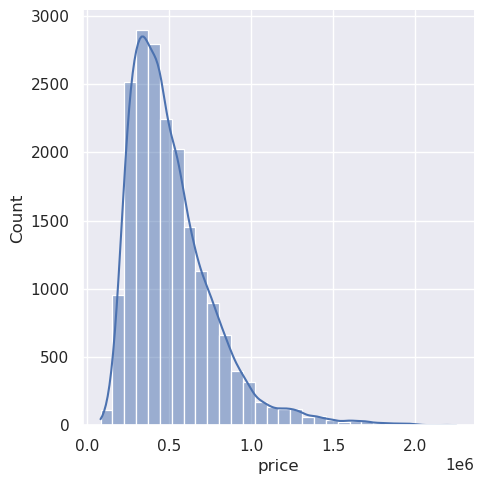

In [47]:
sns.displot(df['price'] , bins=30 , kde=True )
plt.show()

**correlation matrix**

<AxesSubplot:>

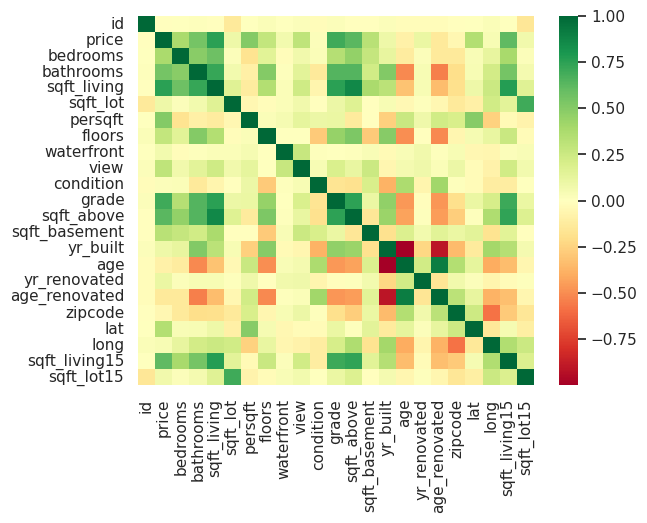

In [48]:
sns.heatmap(df.corr(), annot=False,cmap='RdYlGn')

In [49]:
df3 = df['city'].value_counts().copy()

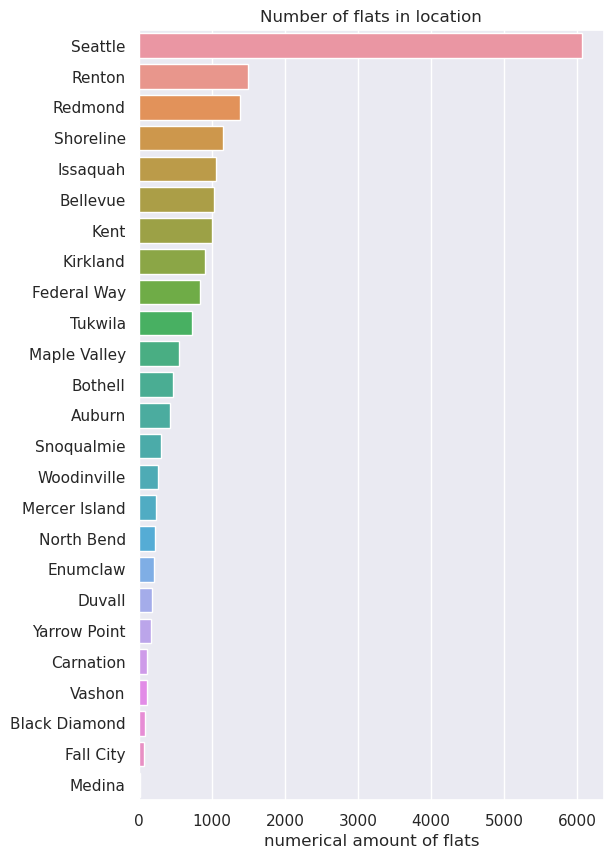

In [50]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df3.values, y=df3.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')
plt.show()

In [51]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'city', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [52]:
df.sort_values('price',ascending=False)[['city']].head(20)

,city
695,Seattle
16751,Seattle
6190,Yarrow Point
16651,Seattle
4273,Seattle
11781,Mercer Island
3952,Issaquah
15978,Seattle
14663,Yarrow Point
17333,Yarrow Point


In [53]:
df.isnull().sum()

id                 0
date               0
price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
persqft            0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
age                0
yr_renovated       0
age_renovated      0
zipcode            0
city             190
lat                0
long               0
sqft_living15      0
sqft_lot15         0
dtype: int64

In [54]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,persqft,floors,waterfront,...,yr_built,age,yr_renovated,age_renovated,zipcode,city,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,"221,900.000",3,1.000,1180,5650,188.051,1.000,0,...,1955,59,0,59,98178,Tukwila,47.511,-122.257,1340,5650
1,6414100192,20141209,"538,000.000",3,2.250,2570,7242,209.339,2.000,0,...,1951,63,1991,23,98125,Seattle,47.721,-122.319,1690,7639
2,5631500400,20150225,"180,000.000",2,1.000,770,10000,233.766,1.000,0,...,1933,82,0,82,98028,Bothell,47.738,-122.233,2720,8062
3,2487200875,20141209,"604,000.000",4,3.000,1960,5000,308.163,1.000,0,...,1965,49,0,49,98136,Seattle,47.521,-122.393,1360,5000
4,1954400510,20150218,"510,000.000",3,2.000,1680,8080,303.571,1.000,0,...,1987,28,0,28,98074,Redmond,47.617,-122.045,1800,7503


In [55]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'city', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

**Calculating the skewness of the data and whether it is near to normal or not?**

In [56]:
skewed = df.copy().drop(['city','id','date'],axis = 1)
print(f"Skewness of features:\n{skewed.skew()}")

Skewness of features:
price            1.646
bedrooms         2.352
bathrooms        0.204
sqft_living      0.816
sqft_lot        11.141
persqft          0.563
floors           0.609
waterfront      18.464
view             3.633
condition        1.087
grade            0.670
sqft_above       1.085
sqft_basement    1.401
yr_built        -0.506
age              0.505
yr_renovated     4.700
age_renovated    0.586
zipcode          0.408
lat             -0.496
long             0.828
sqft_living15    1.007
sqft_lot15       7.610
dtype: float64


**plotting boxplot to scrutinize outliers and acheive a gist of distribution in data**

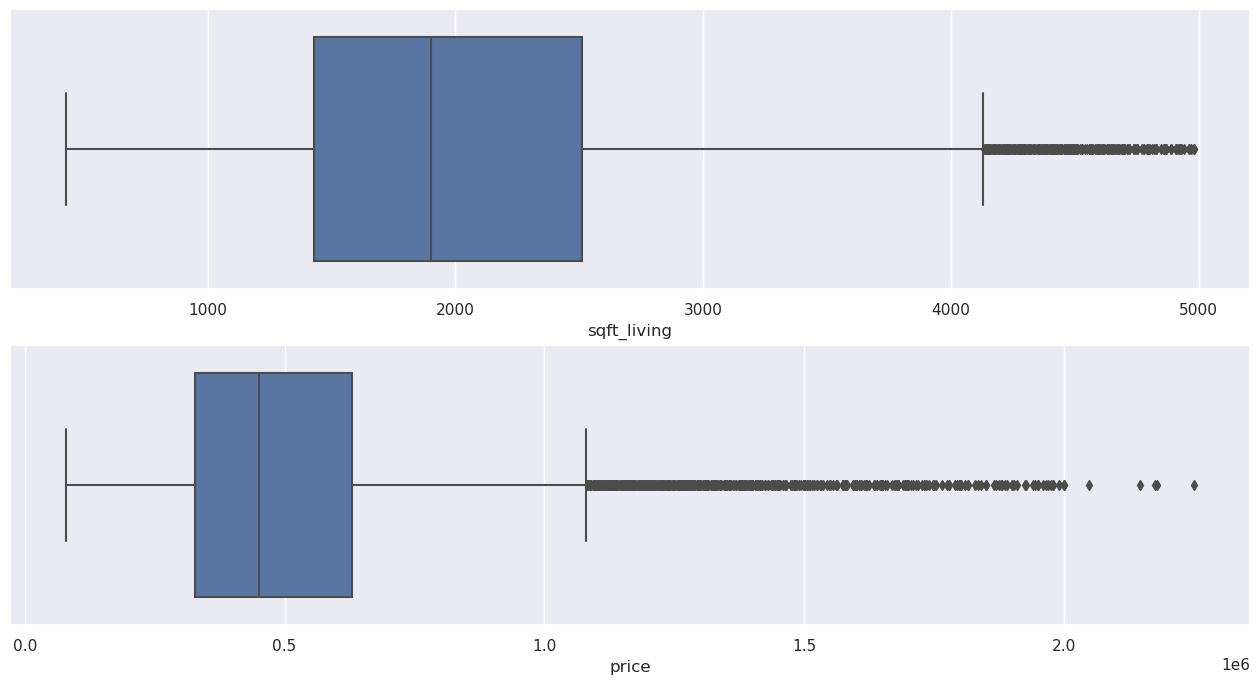

In [57]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['sqft_living'])

plt.subplot(2,1,2)
sns.boxplot(x = df['price'])
plt.show()

In [58]:
#defining a function for determining the upper and lower threshold for 
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(df['sqft_living'])
lower_price, upper_price = lower_upper(df['price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -190.00
Upper limit for area: 4130.00
Lower limit for price: -127,425.0
Upper limit for price: 1,084,375.0


# **omitting outliers**

In [59]:
area_outliers = np.where(df['sqft_living'] > upper_area)
price_outliers = np.where(df['price'] > upper_price)
# Return the unique, sorted array of values that are in either of the two input arrays.
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

Number of area outliers: 364
Number of price outliers: 707
Number of outliers: 861


In [60]:
total_outliers

array([   35,    57,    58,    77,    87,    99,   155,   185,   266,
         267,   330,   340,   377,   390,   412,   413,   423,   425,
         428,   441,   447,   450,   467,   485,   490,   530,   566,
         593,   602,   613,   640,   647,   656,   674,   695,   706,
         713,   714,   734,   783,   790,   839,   846,   956,   967,
         997,  1010,  1011,  1019,  1049,  1073,  1090,  1113,  1125,
        1153,  1227,  1270,  1284,  1288,  1311,  1324,  1333,  1339,
        1362,  1366,  1387,  1413,  1415,  1453,  1499,  1521,  1543,
        1545,  1563,  1577,  1606,  1617,  1618,  1633,  1636,  1674,
        1684,  1718,  1722,  1731,  1732,  1802,  1882,  1941,  1958,
        2006,  2046,  2054,  2065,  2094,  2103,  2123,  2133,  2174,
        2180,  2185,  2189,  2231,  2273,  2274,  2321,  2341,  2429,
        2459,  2468,  2475,  2479,  2499,  2513,  2520,  2521,  2532,
        2555,  2566,  2617,  2688,  2724,  2745,  2769,  2791,  2818,
        2820,  2860,

**Dropping the outliers**

In [61]:
df = df.copy()
df.drop(total_outliers, inplace = True)
df.reset_index(drop = True, inplace = True)
print(f"Shape of new dataset: {df.shape}")

Shape of new dataset: (18396, 25)


In [62]:
skewed = df.copy().drop(['city','id','date'],axis = 1)
print(f"Skewness of features after drop outliers:\n{skewed.skew()}")

Skewness of features after drop outliers:
price            0.696
bedrooms         2.545
bathrooms        0.075
sqft_living      0.585
sqft_lot        11.486
persqft          0.590
floors           0.670
waterfront      20.376
view             3.991
condition        1.070
grade            0.481
sqft_above       0.981
sqft_basement    1.363
yr_built        -0.488
age              0.487
yr_renovated     4.901
age_renovated    0.559
zipcode          0.395
lat             -0.461
long             0.840
sqft_living15    0.829
sqft_lot15       7.730
dtype: float64


<AxesSubplot:xlabel='price'>

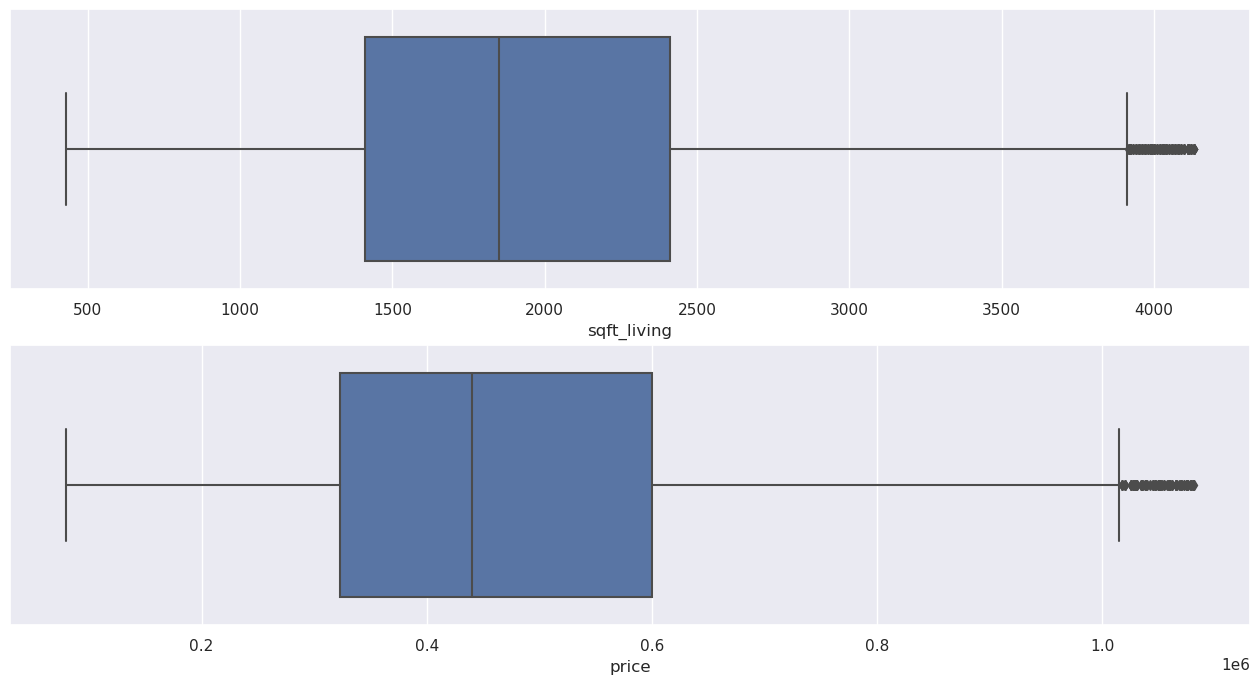

In [63]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['sqft_living'])

plt.subplot(2,1,2)
sns.boxplot(x = df['price'])

**converting city column to some dummy columns or variables**

In [64]:
df_final = df.dropna()

In [65]:
df_final.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
persqft          0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
age              0
yr_renovated     0
age_renovated    0
zipcode          0
city             0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [66]:
dummies = pd.get_dummies(df['city'],drop_first = True)
df_final = df.merge(dummies, left_index = True, right_index = True)
df_final.drop(columns = 'city', inplace = True)
df_final.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,persqft,floors,waterfront,...,North Bend,Redmond,Renton,Seattle,Shoreline,Snoqualmie,Tukwila,Vashon,Woodinville,Yarrow Point
0,7129300520,20141013,"221,900.000",3,1.000,1180,5650,188.051,1.000,0,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,20141209,"538,000.000",3,2.250,2570,7242,209.339,2.000,0,...,0,0,0,1,0,0,0,0,0,0
2,5631500400,20150225,"180,000.000",2,1.000,770,10000,233.766,1.000,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
df_final.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'Bellevue', 'Black Diamond', 'Bothell',
       'Carnation', 'Duvall', 'Enumclaw', 'Fall City', 'Federal Way',
       'Issaquah', 'Kent', 'Kirkland', 'Maple Valley', 'Medina',
       'Mercer Island', 'North Bend', 'Redmond', 'Renton', 'Seattle',
       'Shoreline', 'Snoqualmie', 'Tukwila', 'Vashon', 'Woodinville',
       'Yarrow Point'],
      dtype='object')

**Splitting data to train and test sets**

In [68]:
X = df_final.drop(columns = ['price','id', 'date', 'zipcode'])
y = df_final['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (14716, 44)
shape of y train: (14716,)
shape of x test: (3680, 44)
shape of y train: (3680,)


# defining a function to find the best hyperparameters for any model by means of GridSearchCV method

In [69]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    train_score =grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

# **Implementing the parameter finder function on different models**

**Linear regression**

In [70]:
lr = LinearRegression(n_jobs = -1)

lr_train_score, lr_test_score, lr_RMSE = parameter_finder(lr, {})

The best parameters for LinearRegression model is: {}
--------------------
(R2 score) in the training set is 94.62% for LinearRegression model.
(R2 score) in the testing set is 94.67% for LinearRegression model.
RMSE is 46,183.967595966475 for LinearRegression model.
--------------------
Runtime of the program is: 2.07


# **Ridge, Lasso and ElasticNet Regression**
***Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression.
Ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity.
Lasso regression not only helps in reducing over-fitting but it can help us in feature selection.
Lasso regression can lead to feature selection whereas Ridge can only shrink coefficients close to zero.***(https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)
***By combining lasso and ridge regression we get Elastic-Net Regression. Elastic-Net Regression groups and shrinks the parameters associated with correlated variables and leaves them in the equation or removes them all at once.***(https://medium.com/@corymaklin/machine-learning-algorithms-part-11-ridge-regression-7d5861c2bc76)

In [71]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_train_score, ridge_test_score, ridge_RMSE = parameter_finder(ridge, param_ridge)

The best parameters for Ridge model is: {'alpha': 1}
--------------------
(R2 score) in the training set is 94.62% for Ridge model.
(R2 score) in the testing set is 94.67% for Ridge model.
RMSE is 46,184.23202108678 for Ridge model.
--------------------
Runtime of the program is: 0.45


In [72]:
lasso = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_train_score, lasso_test_score, lasso_RMSE = parameter_finder(lasso, param_lasso)

The best parameters for Lasso model is: {'alpha': 10}
--------------------
(R2 score) in the training set is 94.61% for Lasso model.
(R2 score) in the testing set is 94.67% for Lasso model.
RMSE is 46,204.68712041628 for Lasso model.
--------------------
Runtime of the program is: 10.12


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+13, tolerance: 5.716e+10



In [73]:
eln = ElasticNet(random_state = 1) # Linear regression with combined L1 and L2 priors as regularizer.
param_eln = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}

eln_train_score, eln_test_score, eln_RMSE = parameter_finder(eln, param_eln)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.8622e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+13, tolerance: 4.584e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+13, tolerance: 4.606e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-

The best parameters for ElasticNet model is: {'alpha': 0.001, 'l1_ratio': 0.7}
--------------------
(R2 score) in the training set is 94.61% for ElasticNet model.
(R2 score) in the testing set is 94.67% for ElasticNet model.
RMSE is 46,211.72063841318 for ElasticNet model.
--------------------
Runtime of the program is: 44.86


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e+13, tolerance: 5.716e+10



# **Random Forest and Decision Tree**

In [74]:
dtr = DecisionTreeRegressor(random_state = 1)
param_dtr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_train_score, dtr_test_score, dtr_RMSE = parameter_finder(dtr, param_dtr)

The best parameters for DecisionTreeRegressor model is: {'min_samples_leaf': 3, 'min_samples_split': 2}
--------------------
(R2 score) in the training set is 99.97% for DecisionTreeRegressor model.
(R2 score) in the testing set is 99.82% for DecisionTreeRegressor model.
RMSE is 8,486.404562585878 for DecisionTreeRegressor model.
--------------------
Runtime of the program is: 4.55


In [75]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_train_score, rfr_test_score, rfr_RMSE = parameter_finder(rfr, param_rfr)

The best parameters for RandomForestRegressor model is: {'min_samples_leaf': 2, 'min_samples_split': 2}
--------------------
(R2 score) in the training set is 99.99% for RandomForestRegressor model.
(R2 score) in the testing set is 99.96% for RandomForestRegressor model.
RMSE is 3,894.777618410234 for RandomForestRegressor model.
--------------------
Runtime of the program is: 243.45


# **K-nearest Neighbor**

In [76]:
knr = KNeighborsRegressor(n_jobs = -1)
param_knr = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knr_train_score, knr_test_score, knr_RMSE = parameter_finder(knr, param_knr)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 10, 'weights': 'distance'}
--------------------
(R2 score) in the training set is 100.00% for KNeighborsRegressor model.
(R2 score) in the testing set is 61.09% for KNeighborsRegressor model.
RMSE is 124,818.40253067251 for KNeighborsRegressor model.
--------------------
Runtime of the program is: 34.15


# **XGBoost:**
**Random forest uses a technique called bagging to build full decision trees in parallel from random bootstrap samples of the data set. The final prediction is an average of all of the decision tree predictions.**

**The term “gradient boosting” comes from the idea of “boosting” or improving a single weak model by combining it with a number of other weak models in order to generate a collectively strong model. Gradient boosting is an extension of boosting where the process of additively generating weak models is formalized as a gradient descent algorithm over an objective function. Gradient boosting sets targeted outcomes for the next model in an effort to minimize errors. Targeted outcomes for each case are based on the gradient of the error (hence the name gradient boosting) with respect to the prediction.**

**GBDTs iteratively train an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions. Random forest “bagging” minimizes the variance and overfitting, while GBDT “boosting” minimizes the bias and underfitting.**
https://www.nvidia.com/en-us/glossary/data-science/xgboost/#:~:text=What%20is%20XGBoost%3F,%2C%20classification%2C%20and%20ranking%20problems.

In [77]:
xgboost = XGBRegressor(n_jobs = -1)
param_xgboost = {'n_estimators': [100,300],
             'learning_rate': [0.1,0.05],
             'subsample': [0.75],
             'colsample_bytree': [1],
             'max_depth': [3,4,5],
             'gamma': [0]}

xgboost_train_score, xgboost_test_score, xgboost_RMSE = parameter_finder(xgboost, param_xgboost)

The best parameters for XGBRegressor model is: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.75}
--------------------
(R2 score) in the training set is 99.96% for XGBRegressor model.
(R2 score) in the testing set is 99.95% for XGBRegressor model.
RMSE is 4,477.311891390337 for XGBRegressor model.
--------------------
Runtime of the program is: 148.35


# **Comparing models:**

In [78]:
models_score = pd.DataFrame({'Training score': [lr_train_score, ridge_train_score, lasso_train_score, eln_train_score, dtr_train_score, rfr_train_score, knr_train_score,xgboost_train_score],
                             'Testing score': [lr_test_score, ridge_test_score, lasso_test_score, eln_test_score, dtr_test_score, rfr_test_score, knr_test_score,xgboost_test_score],
                             'RMSE': [lr_RMSE, ridge_RMSE, lasso_RMSE, eln_RMSE, dtr_RMSE, rfr_RMSE, knr_RMSE,xgboost_RMSE]},
                             index = ['LinearRegression', 'Ridge', 'Lasso','ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor','XGBoostRegressor'])

models_score

,Training score,Testing score,RMSE
LinearRegression,0.946,0.947,"46,183.968"
Ridge,0.946,0.947,"46,184.232"
Lasso,0.946,0.947,"46,204.687"
ElasticNet,0.946,0.947,"46,211.721"
DecisionTreeRegressor,1.000,0.998,"8,486.405"
RandomForestRegressor,1.000,1.000,"3,894.778"
KNeighborsRegressor,1.000,0.611,"124,818.403"
XGBoostRegressor,1.000,0.999,"4,477.312"


**Comparing the power of different algorithms by means of figures**

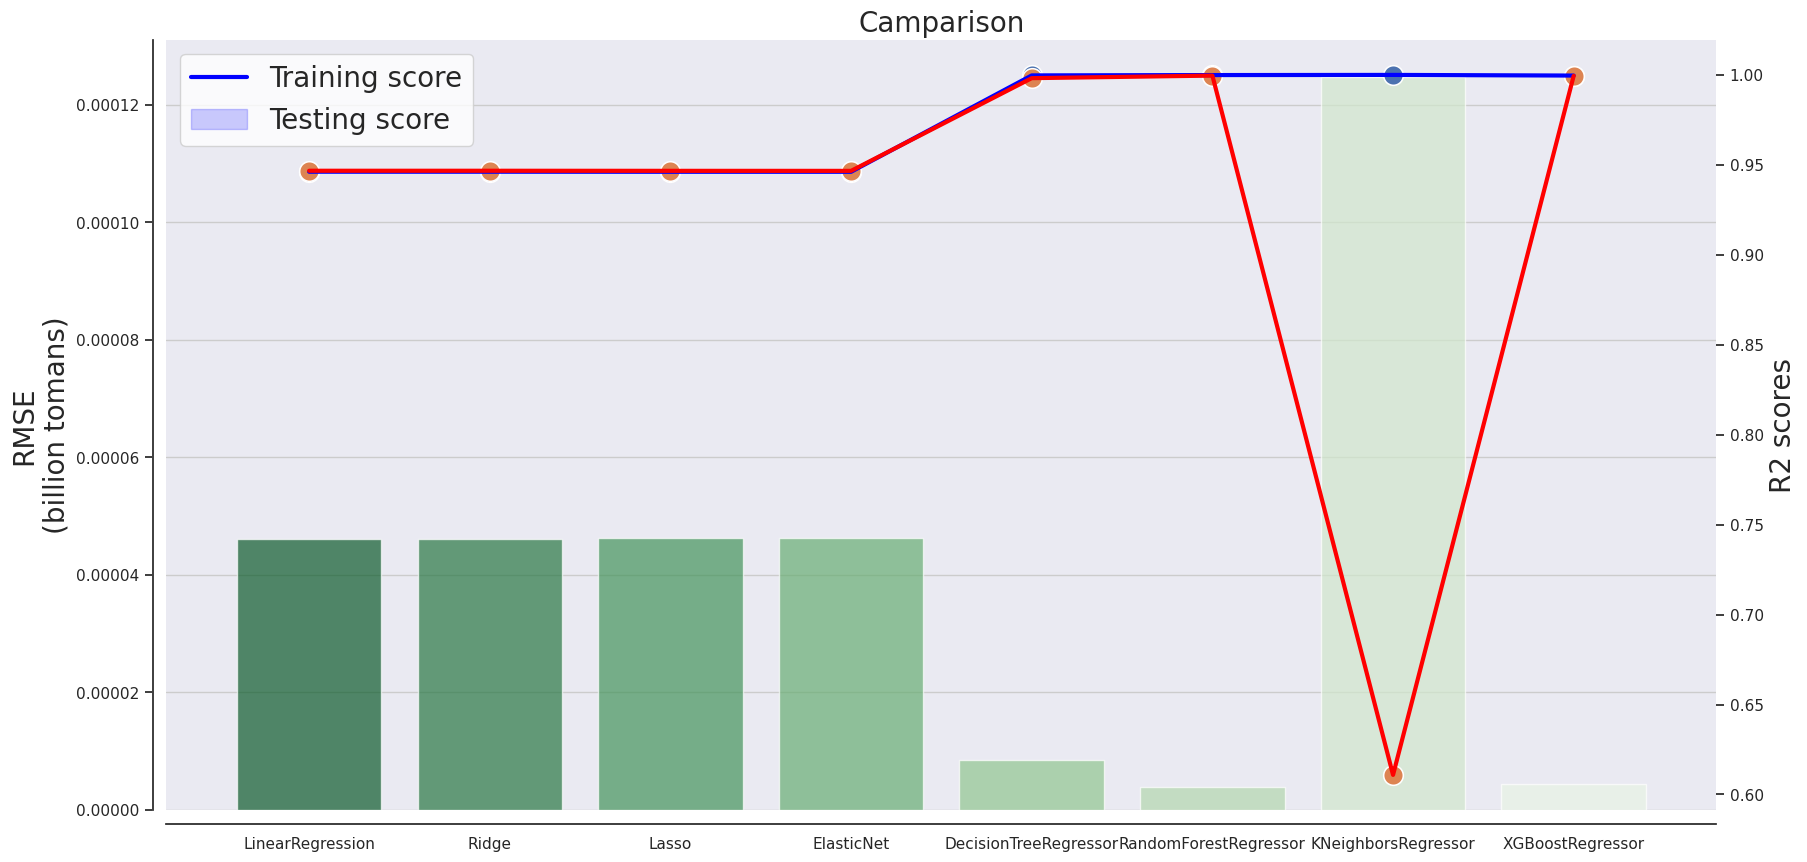

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+13, tolerance: 4.584e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+13, tolerance: 4.575e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [79]:
fig, ax = plt.subplots(figsize=(20,10))

sns.set(style='white')

ax.set_title("Camparison", fontsize = 20)

ax = sns.barplot(x = list(models_score.index), y = models_score['RMSE']/1000000000, alpha = 0.7, palette='Greens_r')

ax.set_ylabel("RMSE\n(billion tomans)", fontsize = 20)

sec_ax = ax.twinx()

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Training score'], linewidth = 3, color = 'blue')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Training score'], s = 200)

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Testing score'], linewidth = 3, color = 'red')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Testing score'], s = 200)

sec_ax.set_ylabel("R2 scores", fontsize = 20)

sec_ax.legend(labels = ['Training score', 'Testing score'], fontsize = 20)


sns.despine(offset = 10)

plt.show()
    